In [1]:
!pip install diffusers

In [2]:
import torch, logging

## disable warnings
logging.disable(logging.WARNING)

## Imaging  library
from PIL import Image
from torchvision import transforms as tfms

## Basic libraries
import numpy as np
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import display
import shutil
import os

## For video display
from IPython.display import HTML
from base64 import b64encode


## Import the CLIP artifacts
from transformers import CLIPTextModel, CLIPTokenizer
from diffusers import AutoencoderKL, UNet2DConditionModel, LMSDiscreteScheduler
from IPython.display import display, clear_output
import os

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

**Helper Functions**

In [5]:

## Initiating tokenizer and encoder.
tokenizer = CLIPTokenizer.from_pretrained("openai/clip-vit-large-patch14", torch_dtype=torch.float16)
text_encoder = CLIPTextModel.from_pretrained("openai/clip-vit-large-patch14", torch_dtype=torch.float16).to("cuda")

## Initiating the VAE
vae = AutoencoderKL.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="vae", torch_dtype=torch.float16).to("cuda")

## Initializing a scheduler and Setting number of sampling steps
scheduler = LMSDiscreteScheduler(beta_start=0.00085, beta_end=0.012, beta_schedule="scaled_linear", num_train_timesteps=1000)
scheduler.set_timesteps(50)

## Initializing the U-Net model
unet = UNet2DConditionModel.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="unet", torch_dtype=torch.float16).to("cuda")


In [6]:
def load_image(p):
    '''
    Function to load images from a defined path
    '''
    return Image.open(p).convert('RGB').resize((512,512))

def pil_to_latents(image):
    '''
    Function to convert image to latents
    '''
    init_image = tfms.ToTensor()(image).unsqueeze(0) * 2.0 - 1.0
    init_image = init_image.to(device="cuda", dtype=torch.float16)
    init_latent_dist = vae.encode(init_image).latent_dist.sample() * 0.18215 #Scaling factor
    return init_latent_dist

def latents_to_pil(latents):
    '''
    Function to convert latents to images
    '''
    latents = (1 / 0.18215) * latents #Rescaling back to the original image size
    with torch.no_grad():
        image = vae.decode(latents).sample
    image = (image / 2 + 0.5).clamp(0, 1)
    image = image.detach().cpu().permute(0, 2, 3, 1).numpy()
    images = (image * 255).round().astype("uint8")
    pil_images = [Image.fromarray(image) for image in images]
    return pil_images

def text_enc(prompts, maxlen=None):
    '''
    A function to take a texual promt and convert it into embeddings
    '''
    if maxlen is None: maxlen = tokenizer.model_max_length
    inp = tokenizer(prompts, padding="max_length", max_length=maxlen, truncation=True, return_tensors="pt")
    return text_encoder(inp.input_ids.to("cuda"))[0].half()

def prompt_2_img(prompts, g=7.5, seed=100, steps=100, dim=512, save_int=True):
    """
    Diffusion process to convert prompt to image
    """

    # Defining batch size
    bs = len(prompts)

    # Converting textual prompts to embedding
    text = text_enc(prompts)

    # Adding an unconditional prompt , helps in the generation process
    uncond =  text_enc([""] * bs, text.shape[1])
    emb = torch.cat([uncond, text])

    # Setting the seed
    if seed: torch.manual_seed(seed)

    # Initiating random noise
    latents = torch.randn((bs, unet.in_channels, dim//8, dim//8))

    # Setting number of steps in scheduler
    scheduler.set_timesteps(steps)

    # Adding noise to the latents
    latents = latents.to("cuda").half() * scheduler.init_noise_sigma

    print("Processing text prompts:", prompts)
    # Just before the loop starts:
    print("Visualizing initial latents...")
    latents_norm = torch.norm(latents.view(latents.shape[0], -1), dim=1).mean().item()
    print(f"Initial Latents Norm: {latents_norm}")

    # Iterating through defined steps
    for i,ts in enumerate(tqdm(scheduler.timesteps)):
        # We need to scale the i/p latents to match the variance
        inp = scheduler.scale_model_input(torch.cat([latents] * 2), ts)

        # Predicting noise residual using U-Net
        with torch.no_grad(): u,t = unet(inp, ts, encoder_hidden_states=emb).sample.chunk(2)

        # Performing Guidance
        pred = u + g*(t-u)

        # Conditioning  the latents
        latents = scheduler.step(pred, ts, latents).prev_sample

        # Inside your loop, after `latents` have been updated:
        latents_norm = torch.norm(latents.view(latents.shape[0], -1), dim=1).mean().item()
        print(f"Step {i+1}/{steps} Latents Norm: {latents_norm}")

        from IPython.display import display, clear_output
        if save_int and i%10==0:
            image_path = f'step2/la_{i:04d}.jpeg'
            latents_to_pil(latents)[0].save(image_path)
            display(latents_to_pil(latents)[0])  # Display the new image

    return latents_to_pil(latents)




Processing text prompts: ['An otter wwaring sunglasses relaxing on a floating tube in a swimming pool, on a sunny day. Realistic']
Visualizing initial latents...
Initial Latents Norm: 1878.0


<ipython-input-6-0053b3e4c71a>:56: FutureWarning: Accessing config attribute `in_channels` directly via 'UNet2DConditionModel' object attribute is deprecated. Please access 'in_channels' over 'UNet2DConditionModel's config object instead, e.g. 'unet.config.in_channels'.
  latents = torch.randn((bs, unet.in_channels, dim//8, dim//8))


  0%|          | 0/100 [00:00<?, ?it/s]

Step 1/100 Latents Norm: 1767.0


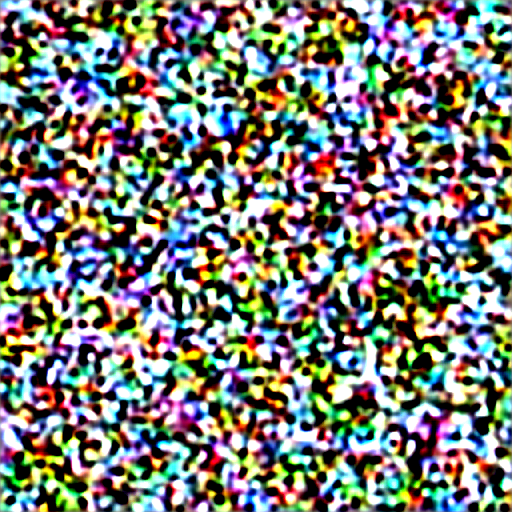

Step 2/100 Latents Norm: 1664.0
Step 3/100 Latents Norm: 1569.0
Step 4/100 Latents Norm: 1481.0
Step 5/100 Latents Norm: 1399.0
Step 6/100 Latents Norm: 1322.0
Step 7/100 Latents Norm: 1251.0
Step 8/100 Latents Norm: 1185.0
Step 9/100 Latents Norm: 1123.0
Step 10/100 Latents Norm: 1066.0
Step 11/100 Latents Norm: 1011.5


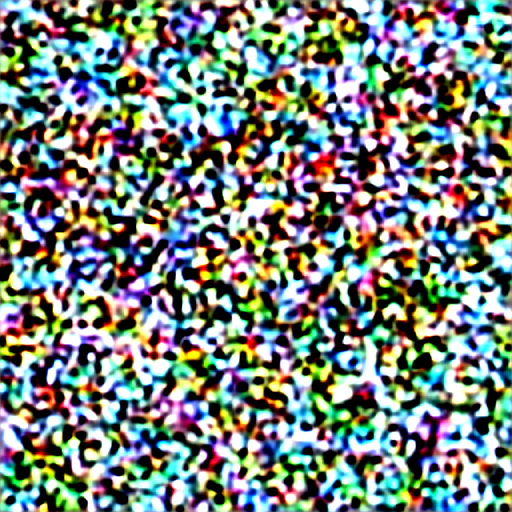

Step 12/100 Latents Norm: 961.5
Step 13/100 Latents Norm: 914.5
Step 14/100 Latents Norm: 870.5
Step 15/100 Latents Norm: 829.0
Step 16/100 Latents Norm: 790.0
Step 17/100 Latents Norm: 754.0
Step 18/100 Latents Norm: 720.0
Step 19/100 Latents Norm: 688.0
Step 20/100 Latents Norm: 658.0
Step 21/100 Latents Norm: 629.5


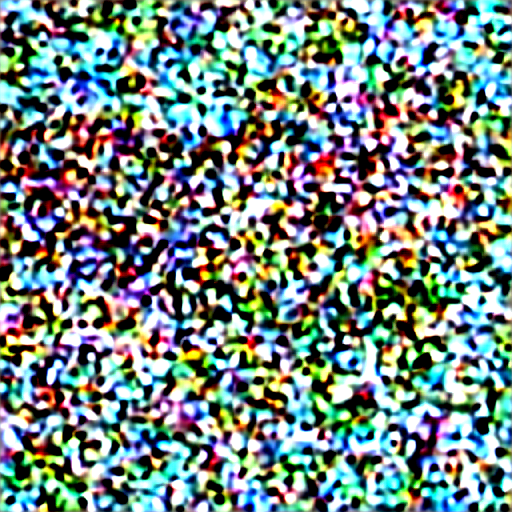

Step 22/100 Latents Norm: 603.0
Step 23/100 Latents Norm: 578.0
Step 24/100 Latents Norm: 554.5
Step 25/100 Latents Norm: 532.0
Step 26/100 Latents Norm: 511.25
Step 27/100 Latents Norm: 491.5
Step 28/100 Latents Norm: 472.75
Step 29/100 Latents Norm: 455.0
Step 30/100 Latents Norm: 438.5
Step 31/100 Latents Norm: 422.75


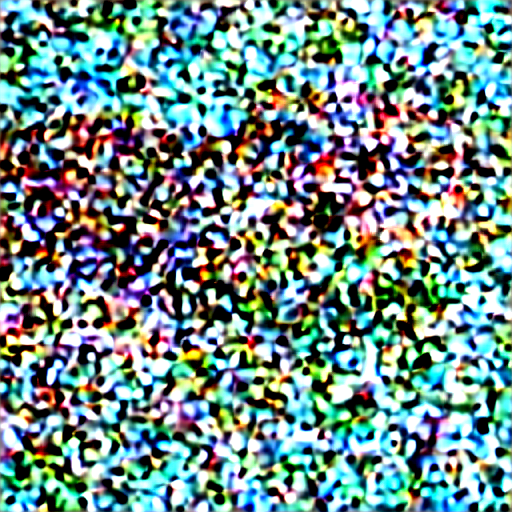

Step 32/100 Latents Norm: 407.75
Step 33/100 Latents Norm: 393.5
Step 34/100 Latents Norm: 380.25
Step 35/100 Latents Norm: 367.5
Step 36/100 Latents Norm: 355.5
Step 37/100 Latents Norm: 344.0
Step 38/100 Latents Norm: 333.0
Step 39/100 Latents Norm: 322.75
Step 40/100 Latents Norm: 313.0
Step 41/100 Latents Norm: 303.75


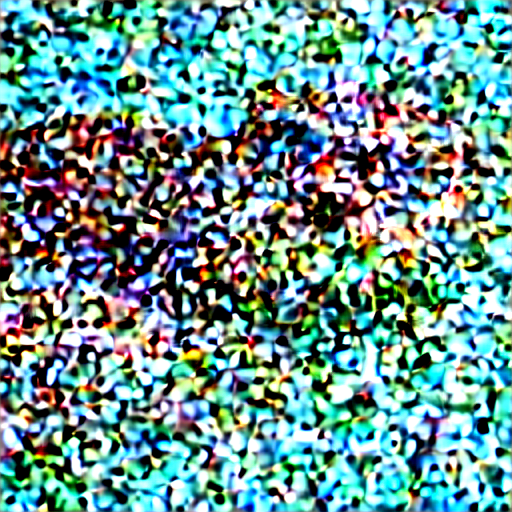

Step 42/100 Latents Norm: 294.75
Step 43/100 Latents Norm: 286.25
Step 44/100 Latents Norm: 278.25
Step 45/100 Latents Norm: 270.75
Step 46/100 Latents Norm: 263.25
Step 47/100 Latents Norm: 256.5
Step 48/100 Latents Norm: 249.75
Step 49/100 Latents Norm: 243.5
Step 50/100 Latents Norm: 237.5
Step 51/100 Latents Norm: 231.75


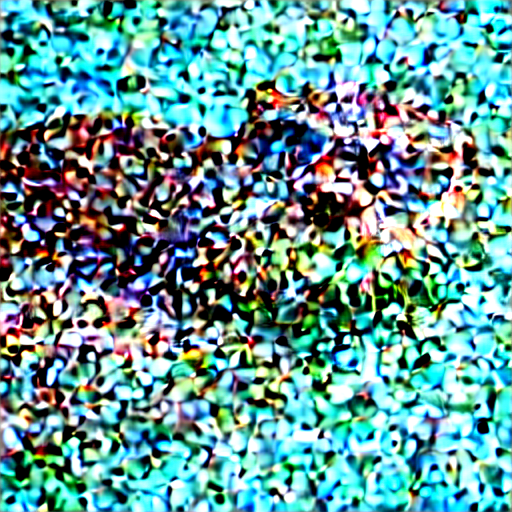

Step 52/100 Latents Norm: 226.25
Step 53/100 Latents Norm: 221.0
Step 54/100 Latents Norm: 216.0
Step 55/100 Latents Norm: 211.25
Step 56/100 Latents Norm: 206.625
Step 57/100 Latents Norm: 202.25
Step 58/100 Latents Norm: 198.125
Step 59/100 Latents Norm: 194.125
Step 60/100 Latents Norm: 190.375
Step 61/100 Latents Norm: 186.75


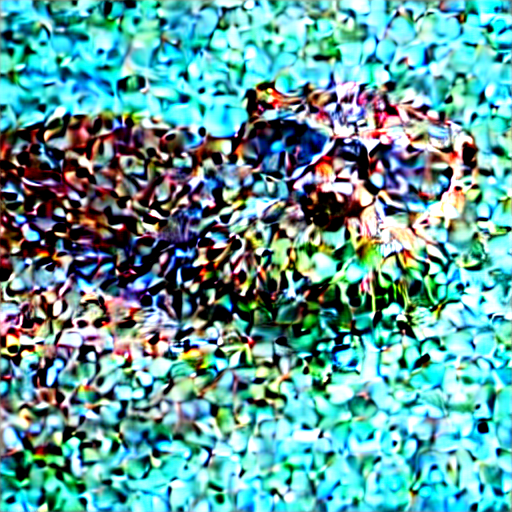

Step 62/100 Latents Norm: 183.25
Step 63/100 Latents Norm: 179.875
Step 64/100 Latents Norm: 176.75
Step 65/100 Latents Norm: 173.625
Step 66/100 Latents Norm: 170.75
Step 67/100 Latents Norm: 168.0
Step 68/100 Latents Norm: 165.25
Step 69/100 Latents Norm: 162.75
Step 70/100 Latents Norm: 160.25
Step 71/100 Latents Norm: 158.0


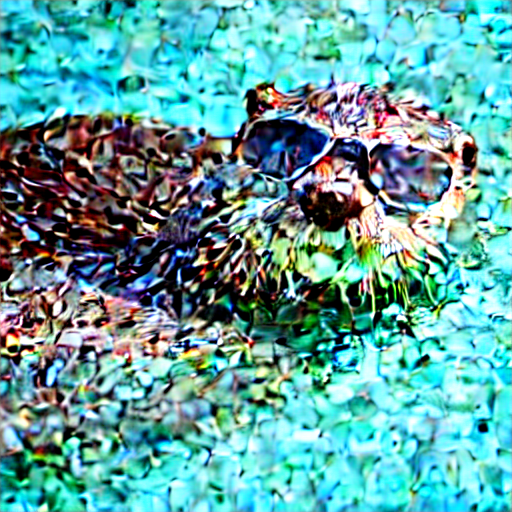

Step 72/100 Latents Norm: 155.75
Step 73/100 Latents Norm: 153.5
Step 74/100 Latents Norm: 151.5
Step 75/100 Latents Norm: 149.5
Step 76/100 Latents Norm: 147.625
Step 77/100 Latents Norm: 145.875
Step 78/100 Latents Norm: 144.125
Step 79/100 Latents Norm: 142.375
Step 80/100 Latents Norm: 140.875
Step 81/100 Latents Norm: 139.375


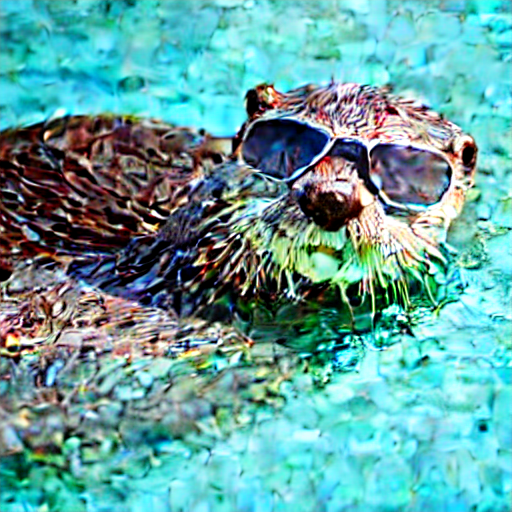

Step 82/100 Latents Norm: 137.875
Step 83/100 Latents Norm: 136.5
Step 84/100 Latents Norm: 135.25
Step 85/100 Latents Norm: 134.0
Step 86/100 Latents Norm: 132.75
Step 87/100 Latents Norm: 131.625
Step 88/100 Latents Norm: 130.5
Step 89/100 Latents Norm: 129.5
Step 90/100 Latents Norm: 128.5
Step 91/100 Latents Norm: 127.5


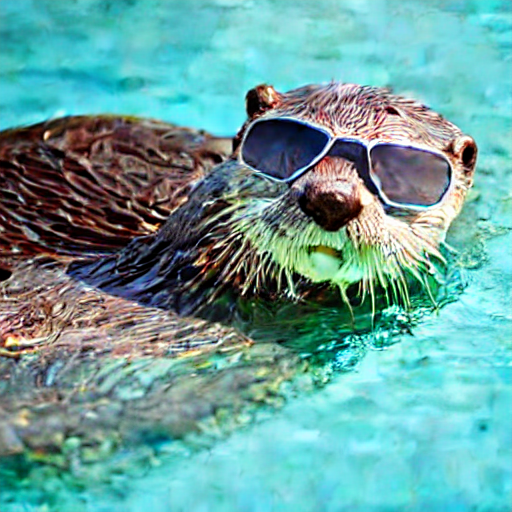

Step 92/100 Latents Norm: 126.625
Step 93/100 Latents Norm: 125.75
Step 94/100 Latents Norm: 124.9375
Step 95/100 Latents Norm: 124.1875
Step 96/100 Latents Norm: 123.4375
Step 97/100 Latents Norm: 122.75
Step 98/100 Latents Norm: 122.125
Step 99/100 Latents Norm: 121.5
Step 100/100 Latents Norm: 121.375


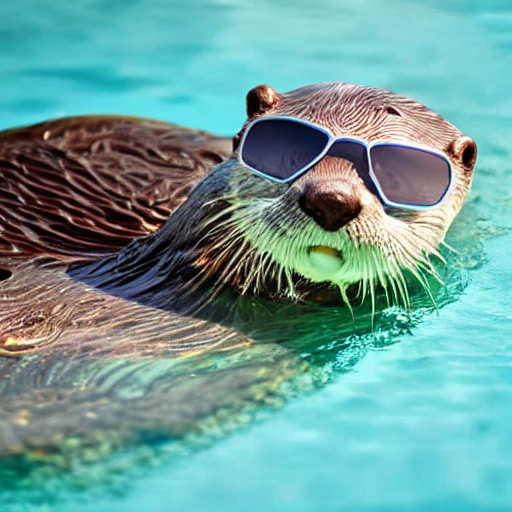

In [13]:
images = prompt_2_img(["An otter wwaring sunglasses relaxing on a floating tube in a swimming pool, on a sunny day. Realistic"], save_int=True)
for img in images:display(img)


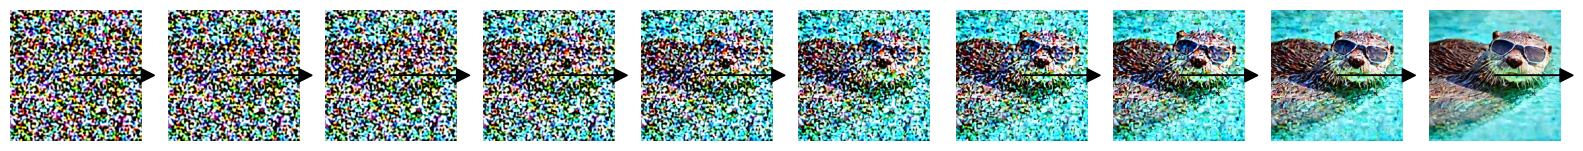

In [14]:
import os
import matplotlib.pyplot as plt

def visualize_steps(folder='/content/step2'):
    # Get list of all files in the folder
    files = os.listdir(folder)
    # Filter only image files
    image_files = [file for file in files if file.endswith('.jpeg')]
    num_steps = len(image_files)

    fig, axs = plt.subplots(1, num_steps, figsize=(20, 10))
    for ax, img_file in zip(axs, sorted(image_files)):  # Sort to ensure proper ordering
        img_path = os.path.join(folder, img_file)
        img = plt.imread(img_path)
        ax.imshow(img)
        ax.axis('off')  # Turn off axis numbering and ticks

        # Add arrows (except for the last image)
        if img_file != image_files[0]:
            ax.arrow(0.5, 0.5, 0.5, 0, head_width=0.1, head_length=0.1, fc='k', ec='k',transform=ax.transAxes, clip_on=False)

    plt.show()

# Call the function to display the visualization
visualize_steps()
